## cGAN generate LiDAR

In [1]:
import os
import io
import cv2
import copy
import math
import wandb
import random
import numpy as np
import pickle as pkl
from collections import deque
from tqdm import tqdm, trange
from typing import Deque, Dict, List, Tuple
import matplotlib.pyplot as plt


import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.autograd import Variable
from torch.utils.data.dataset import Dataset
from torch.utils.data import DataLoader, random_split



## dataset

In [2]:
paths = []
main_path = '/media/ray/intelSSD/mmdemo_train'
dirs = os.listdir(main_path)
dirs.sort()
for d in dirs:
    dirs1 = os.listdir(main_path+'/'+d)
    dirs1.sort()
    dirs2 = os.listdir(main_path+'/'+d+'/'+dirs1[1])
    dirs2.sort()
    for d2 in dirs2: 
        paths.append(main_path+'/'+d+'/'+dirs1[1]+'/'+d2)
        print(paths[-1])
print('%d episodes'%len(paths))


/media/ray/intelSSD/mmdemo_train/mmdemo_0717_1411/transition_0717_1411/mmdemo_trans_0717_1411_000.pkl
/media/ray/intelSSD/mmdemo_train/mmdemo_0717_1411/transition_0717_1411/mmdemo_trans_0717_1411_001.pkl
/media/ray/intelSSD/mmdemo_train/mmdemo_0717_1411/transition_0717_1411/mmdemo_trans_0717_1411_002.pkl
/media/ray/intelSSD/mmdemo_train/mmdemo_0717_1411/transition_0717_1411/mmdemo_trans_0717_1411_003.pkl
/media/ray/intelSSD/mmdemo_train/mmdemo_0717_1411/transition_0717_1411/mmdemo_trans_0717_1411_004.pkl
/media/ray/intelSSD/mmdemo_train/mmdemo_0717_1426/transition_0717_1426/mmdemo_trans_0717_1426_000.pkl
/media/ray/intelSSD/mmdemo_train/mmdemo_0717_1426/transition_0717_1426/mmdemo_trans_0717_1426_001.pkl
/media/ray/intelSSD/mmdemo_train/mmdemo_0717_1426/transition_0717_1426/mmdemo_trans_0717_1426_002.pkl
/media/ray/intelSSD/mmdemo_train/mmdemo_0717_1454/transition_0717_1454/mmdemo_trans_0717_1454_000.pkl
/media/ray/intelSSD/mmdemo_train/mmdemo_0717_1454/transition_0717_1454/mmdemo_tran

In [3]:
class MMDataset(Dataset):
    def __init__(self, paths):
        self.transitions = []

        for p in tqdm(paths):
            with open(p, "rb") as f:
                demo = pkl.load(f, encoding="bytes")
                self.transitions.extend(demo)
        
    def __getitem__(self,index):
        mm_scan = self.transitions[index][b'mm_scan']
        laser_scan = self.transitions[index][b'laser_scan']
        mm_scan = torch.Tensor(mm_scan).reshape(1,-1)
        laser_scan = torch.Tensor(laser_scan).reshape(1,-1)
        
        return mm_scan, laser_scan
    
    def __len__(self):
        return len(self.transitions)

    
batch_size = 16
mm_dataset = MMDataset(paths)

loader = DataLoader(dataset=mm_dataset,
                    batch_size=batch_size,
                    shuffle=True,
                    num_workers=4)


100%|██████████| 228/228 [00:02<00:00, 90.39it/s]


## hyper parameters

In [4]:
hyper_parameter = dict(
    kernel=3,
    stride=2,
    padding=2,
    deconv_dim=32,
    deconv_channel=128,
    adjust_linear=235,
    epoch=500,
    beta1=0.5,
    learning_rate=0.0002,
    nz=100,
    lambda_l1=100,
)
class Struct:
    def __init__(self, **entries):
        self.__dict__.update(entries)
config = Struct(**hyper_parameter)

## model

In [5]:
class Generator(nn.Module):
    def __init__(self):
        super(Generator, self).__init__()
        kernel = 3
        stride = 2
        self.conv = nn.Sequential(
            nn.Conv1d(1, 64, kernel_size=kernel, stride=stride),
            nn.ReLU(),
            nn.Conv1d(64, 64, kernel_size=kernel, stride=stride),
            nn.ReLU()
        )
        
        dim = 64*59
        self.linear=nn.Sequential(
            nn.Linear(dim,512),
            nn.ReLU(),
            nn.Linear(512,128)
        )
        
#         self.n_fc1=nn.Linear(config.nz, 128)
#         self.n_fc2=nn.Linear(128, 128)
        
#         self.fc_combine=nn.Linear(128*2, 128)
        
        self.de_fc1=nn.Sequential(
            nn.Linear(128,config.deconv_channel*config.deconv_dim),
            nn.ReLU()
        )
        
        self.de_conv =nn.Sequential(
            nn.ConvTranspose1d(config.deconv_channel, config.deconv_channel//2, kernel, stride=stride, padding=config.padding),
            nn.ConvTranspose1d(config.deconv_channel//2, config.deconv_channel//4, kernel, stride=stride, padding=config.padding),
            nn.ConvTranspose1d(config.deconv_channel//4, 1, kernel, stride=stride, padding=config.padding),
        )
        self.adjust_linear=nn.Sequential(
            nn.Linear(config.adjust_linear,241),
            nn.ReLU()
        )

        
    def encoder(self,x):
        x = self.conv(x)
        x = x.view(x.size(0),-1)
        x = self.linear(x)
        return x

    def decoder(self,x):
        x = self.de_fc1(x)
        x = x.view(-1, config.deconv_channel, config.deconv_dim)
        x = self.de_conv(x)
        x = self.adjust_linear(x)
        return x

    def forward(self, x):
        x = self.encoder(x)
#         n = self.n_fc1(n)
#         n = self.n_fc2(n)
        
#         x = torch.cat((x,n),dim=-1)
#         x = self.fc_combine(x)
        
        x = self.decoder(x)
        return x

In [6]:
class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        kernel = 3
        stride = 2
        self.conv = nn.Sequential(
            nn.Conv1d(2, 64, kernel_size=kernel, stride=stride),
            nn.ReLU(),
            nn.Conv1d(64, 64, kernel_size=kernel, stride=stride),
            nn.ReLU()
        )
        
        dim = 64*59
        self.linear=nn.Sequential(
            nn.Linear(dim,512),
            nn.ReLU(),
            nn.Linear(512,128),
            nn.ReLU(),
            nn.Linear(128, 1),
            nn.Sigmoid(),
        )

    def forward(self, x):
                
        x = self.conv(x)
        x = x.view(x.size(0),-1)
        x = self.linear(x)
        
        return x

## test

In [7]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print('device, ',device)
model = Generator()

# lsgan  L1:0.1167
# model_path = "/home/ray/subt-analyze/09-mmwave-cGAN/generate_lidar/wandb/run-20200827_181923-2ikdkpzj/model.pth"

# bce logits loss L1:0.1163
model_path = '/home/ray/subt-analyze/09-mmwave-cGAN/generate_lidar/wandb/run-20200827_185124-1wnumweh/model.pth'

# patched lsgan L1: 0.1631
# model_path = '/home/ray/subt-analyze/09-mmwave-cGAN/generate_lidar/wandb/run-20200828_153610-1x2nrzhi/model.pth'

model.load_state_dict(torch.load(model_path))
model.to(device)


device,  cuda:0


Generator(
  (conv): Sequential(
    (0): Conv1d(1, 64, kernel_size=(3,), stride=(2,))
    (1): ReLU()
    (2): Conv1d(64, 64, kernel_size=(3,), stride=(2,))
    (3): ReLU()
  )
  (linear): Sequential(
    (0): Linear(in_features=3776, out_features=512, bias=True)
    (1): ReLU()
    (2): Linear(in_features=512, out_features=128, bias=True)
  )
  (de_fc1): Sequential(
    (0): Linear(in_features=128, out_features=4096, bias=True)
    (1): ReLU()
  )
  (de_conv): Sequential(
    (0): ConvTranspose1d(128, 64, kernel_size=(3,), stride=(2,), padding=(2,))
    (1): ConvTranspose1d(64, 32, kernel_size=(3,), stride=(2,), padding=(2,))
    (2): ConvTranspose1d(32, 1, kernel_size=(3,), stride=(2,), padding=(2,))
  )
  (adjust_linear): Sequential(
    (0): Linear(in_features=235, out_features=241, bias=True)
    (1): ReLU()
  )
)

## visualize

In [8]:
def laser_visual(lasers=[], show=False, range_limit=6):
    colors = ['#3483EB','#FFA500','#15B01D']
#     fig = plt.figure(figsize=(8, 8))
    for i, l in enumerate(lasers):
        fig = plt.figure(figsize=(8, 8))
        angle = 120
        xp = []
        yp = []
        for r in l:
            if r <= range_limit:
                yp.append(r * math.cos(math.radians(angle)))
                xp.append(r * math.sin(math.radians(angle)))
            angle -= 1
        plt.xlim(-6, 6)
        plt.ylim(-6, 6)
        plt.axis('off')
        plt.plot(xp, yp, 'x', color=colors[i])
        plt.show()


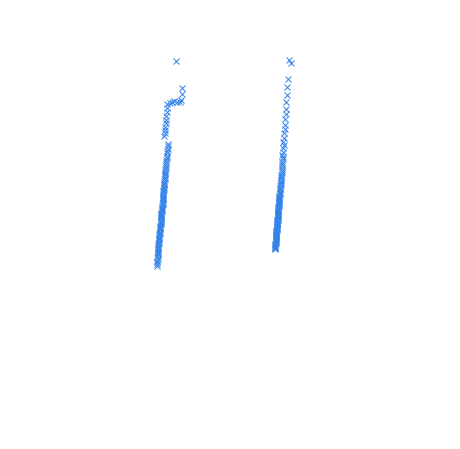

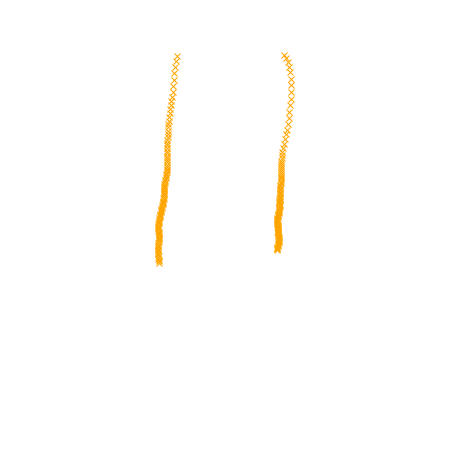

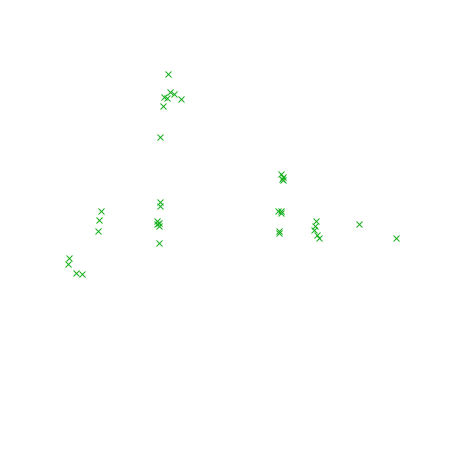

In [9]:
data1 = None
for mm_scan, laser_scan in loader:
    mm_scan = mm_scan.to(device)
    x_hat = model(mm_scan)
    
    x = x_hat.detach().cpu().numpy().reshape(batch_size,-1)[0]
    laser = laser_scan.numpy().reshape(batch_size,-1)[0]
    mm = mm_scan.detach().cpu().numpy().reshape(batch_size,-1)[0]
    
    laser_visual([laser, x, mm], show=True, range_limit=4.9)
    data1 = [laser, x, mm]
    
    break

## save

In [10]:

with open('visual_demo/laser.pkl', 'wb') as f:
    pkl.dump(laser, f)
    
with open('visual_demo/mm.pkl', 'wb') as f:
    pkl.dump(mm, f)
    
with open('visual_demo/cGAN.pkl', 'wb') as f:
    pkl.dump(x, f)
    
print('save')


save


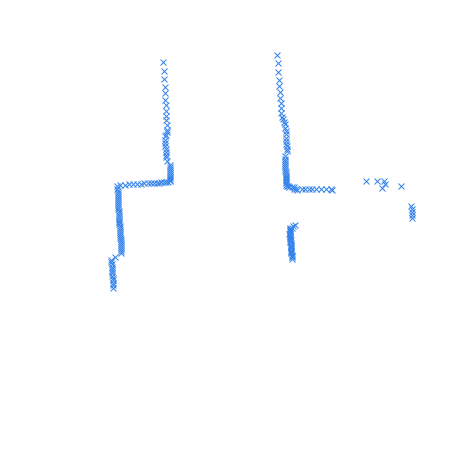

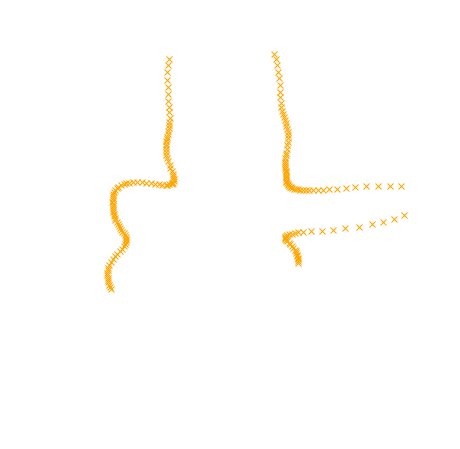

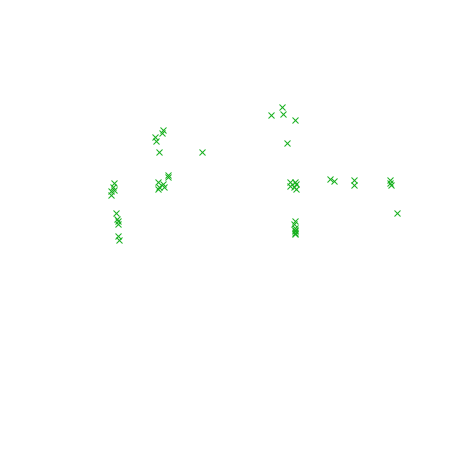

In [11]:
data2 = None
for mm_scan, laser_scan in loader:
    mm_scan = mm_scan.to(device)
    x_hat = model(mm_scan)
    
    x = x_hat.detach().cpu().numpy().reshape(batch_size,-1)[0]
    laser = laser_scan.numpy().reshape(batch_size,-1)[0]
    mm = mm_scan.detach().cpu().numpy().reshape(batch_size,-1)[0]
    
    laser_visual([laser, x, mm], show=True, range_limit=4.9)
    data2 = [laser, x, mm]
    
    break

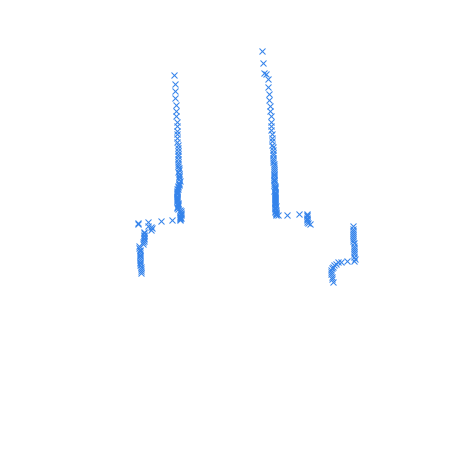

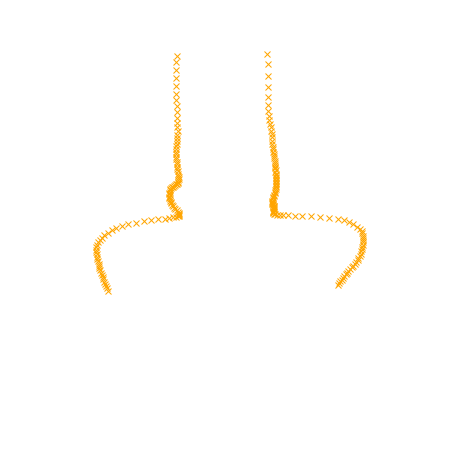

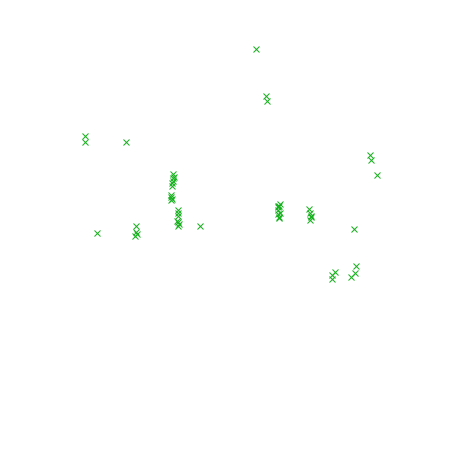

In [12]:
data3 = None
for mm_scan, laser_scan in loader:
    mm_scan = mm_scan.to(device)
    x_hat = model(mm_scan)
    
    x = x_hat.detach().cpu().numpy().reshape(batch_size,-1)[0]
    laser = laser_scan.numpy().reshape(batch_size,-1)[0]
    mm = mm_scan.detach().cpu().numpy().reshape(batch_size,-1)[0]
    
    laser_visual([laser, x, mm], show=True, range_limit=4.9)
    data3 = [laser, x, mm]
    
    break

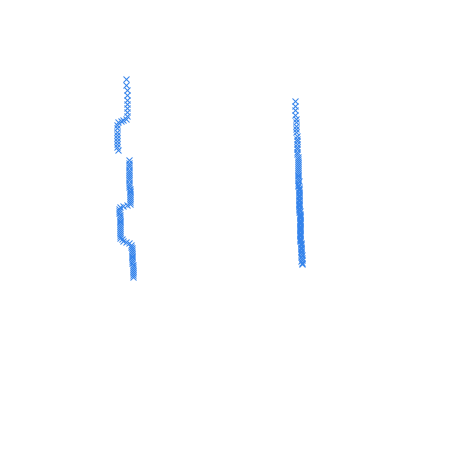

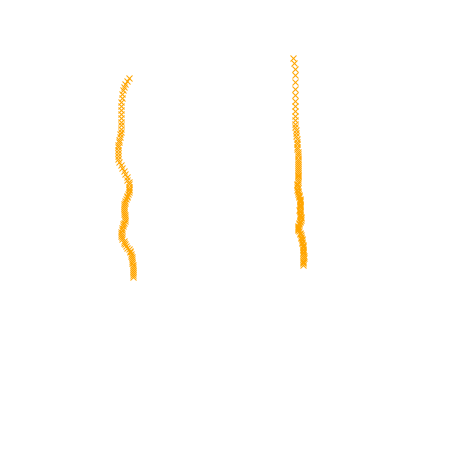

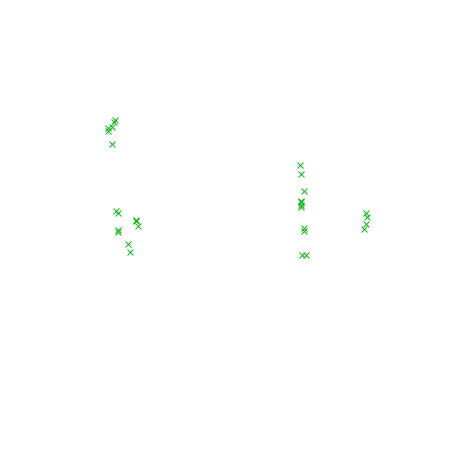

In [13]:
data4 = None
for mm_scan, laser_scan in loader:
    mm_scan = mm_scan.to(device)
    x_hat = model(mm_scan)
    
    x = x_hat.detach().cpu().numpy().reshape(batch_size,-1)[0]
    laser = laser_scan.numpy().reshape(batch_size,-1)[0]
    mm = mm_scan.detach().cpu().numpy().reshape(batch_size,-1)[0]
    
    laser_visual([laser, x, mm], show=True, range_limit=4.9)
    data4 = [laser, x, mm]
    
    break

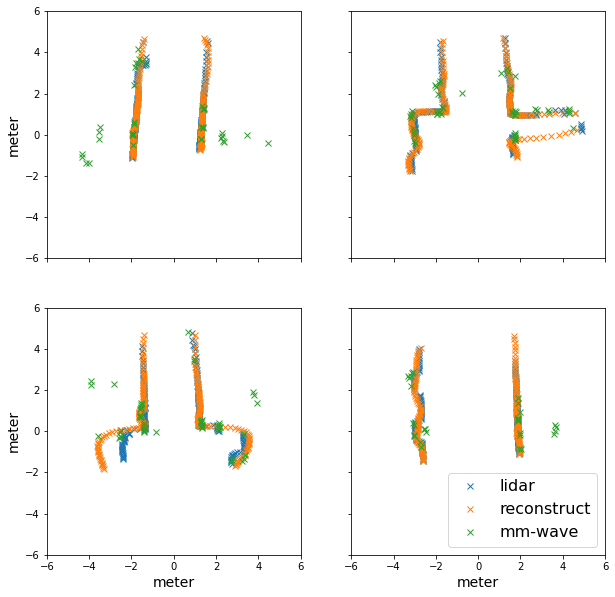

In [14]:
def laser_visual_one(lasers, axs, range_limit=4.9):
    labels = ['lidar', 'reconstruct', 'mm-wave']
    for i,l in enumerate(lasers):
        angle = 120
        xp = []
        yp = []
        for r in l:
            if r <= range_limit:
                yp.append(r * math.cos(math.radians(angle)))
                xp.append(r * math.sin(math.radians(angle)))
            angle -= 1
        axs.set_xlim([-6,6])
        axs.set_ylim([-6,6])
        axs.plot(xp,yp,'x',label=labels[i])
        
fig, axs = plt.subplots(2, 2)
fig.set_figheight(10)
fig.set_figwidth(10)

laser_visual_one(data1,axs[0,0])
# axs[0, 0].set_title('Axis [0,0]')

laser_visual_one(data2,axs[0,1])
# axs[0, 1].set_title('Axis [0,1]')

laser_visual_one(data3,axs[1,0])
# axs[1, 0].set_title('Axis [1,0]')

laser_visual_one(data4,axs[1,1])
# axs[1, 1].set_title('Axis [1,1]')

for ax in axs.flat:
    ax.set_xlabel('meter', fontsize=14)
    ax.set_ylabel('meter', fontsize=14)

# Hide x labels and tick labels for top plots and y ticks for right plots.
for ax in axs.flat:
    ax.label_outer()
    
# ax.legend(prop={'size': 18}, bbox_to_anchor=(0.3, 0.9))
ax.legend(loc='lower right', prop={'size': 16})


plt.show()